# Trying ensemble models to have better prediction for "Target" 

As saw in previous steps, the best models for our binary prediction of "Target" are:
- KNN, on SMOTE Dataset
- Neural Network, on SMOTE Dataset
- LightGBM, on original Dataset

Optimized parameters are found in others notebook via a GridSearch. So now, we will try to test different way to combine the prediction directly on the final prediction

After that, we will be able to combine this prediction with Failure Type prediction to obtain our final y_pred.

#### Importing librairies

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
!pip install lightgbm

#### Importing models

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression


#### Loading datasets

In [5]:
#training
X_train = pd.read_csv('X_train.csv', sep=',')
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train = pd.read_csv('y_train.csv', sep=',')
y_train_target = y_train['Target'] 
y_train_target.columns = ['Target']

#SMOTE for Target for KNN and NN models 
X_train_smote = pd.read_csv('X_train_resampled_target.csv', sep=',')
X_train_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train_smote.columns]
y_train_smote = pd.read_csv('y_train_resampled_target.csv', sep=',')
y_train_smote_target = y_train_smote['Target']
y_train_smote_target.columns = ['Target']


#testing
X_test = pd.read_csv('X_test.csv', sep=',')
X_test.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_test.columns]

y_test = pd.read_csv('y_test.csv', sep=',')
y_test_target = y_test['Target']
y_test_target.columns = ['Target']


Defining our base models with the optimized parameters found during GridSearch

In [25]:
knn = KNeighborsClassifier(
    metric = 'manhattan', 
    n_neighbors = 11, 
    p = 1, 
    weights = 'distance')

nn = MLPClassifier(
    activation = 'tanh', 
    alpha = 0.001, 
    batch_size = 64, 
    hidden_layer_sizes = (64, 64, 32), 
    learning_rate_init = 0.001)

lightgbm = LGBMClassifier(
    learning_rate = 0.01, 
    max_depth = 3, 
    n_estimators = 100, 
    num_leaves = 31, 
    subsample = 0.8,
    verbose=-1)

base_models = [('knn', knn),
               ('nn', nn)]

## With a Stacking Classifier between the three models

Trying to put LightGBM as the meta model to see

In [26]:
meta_model = lightgbm

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)


C:\Users\hindi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluation of the Stacking

In [27]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.5084745762711864 | Accuracy: 0.9328 | F1-score: 0.3093


#### Visualization of the Stacking prediction

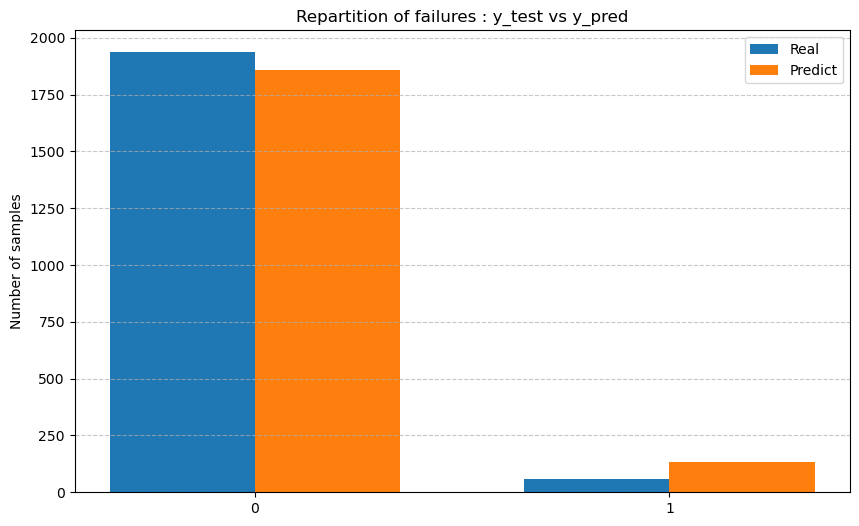

In [22]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The first prediction is **not really good**: **low recall** even though accuracy is pretty high, and it predicted **too much failures**.

## Same but with Logistic Regression as a meta model (which is more usual)

In [23]:
logreg = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=logreg)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)


Evaluation of the Stacking

In [24]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.6101694915254238 | Accuracy: 0.9238 | F1-score: 0.3214


#### Visualization of the Stacking prediction

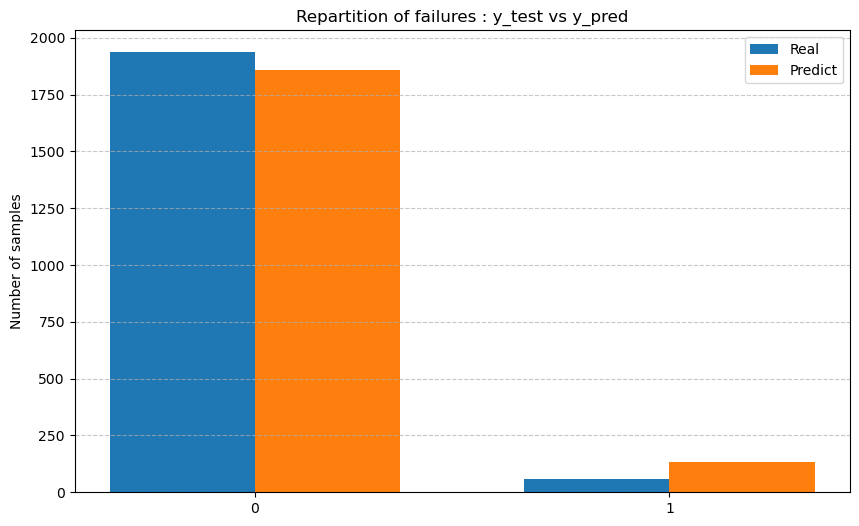

In [28]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Recall is a little bit higher, accuracy a little lower, but we can keep searching. Using Logreg aas a meta model might seems better as LightGBM.

## With a Voting Classifier only between KNN and NN

Only between KNN and NN because Voting Classifier needs to be train on one model, but LightGBM donesn't use the same dataset as KNN and NN. 
So, as a compromise, we only use KNN and NN in the Voting Classifier.

In [29]:
voting_clf = VotingClassifier(
    estimators=base_models,
    voting='hard',   
    n_jobs=-1
)

voting_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = voting_clf.predict(X_test)


Evaluation of the Voting Classifier

In [30]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.6610169491525424 | Accuracy: 0.8772 | F1-score: 0.2415


#### Visualization of the Stacking prediction

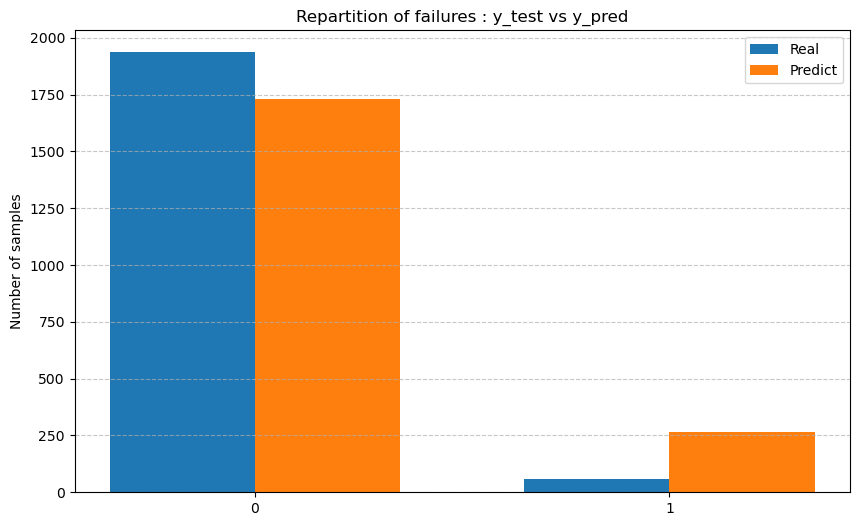

In [31]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

Higher recall, but too many failures are predicted which might slows down the prediction of Failure Type in the following events.

## With Bagging models then Voting Classifier

To permit the Voting between the three models, Voting classifier is fit with original dataset so no smote here.

In [36]:
bag_knn = BaggingClassifier(
    estimator=knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_knn', bag_knn),
        ('bag_nn', bag_nn),
        ('bag_lightgbm', bag_lightgbm)
    ],
    voting='hard', 
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_target)

y_pred_target = voting_clf.predict(X_test)

Evaluation

In [37]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.06779661016949153 | Accuracy: 0.9724 | F1-score: 0.1270


#### Visualization of Bagging then Voting Classifier

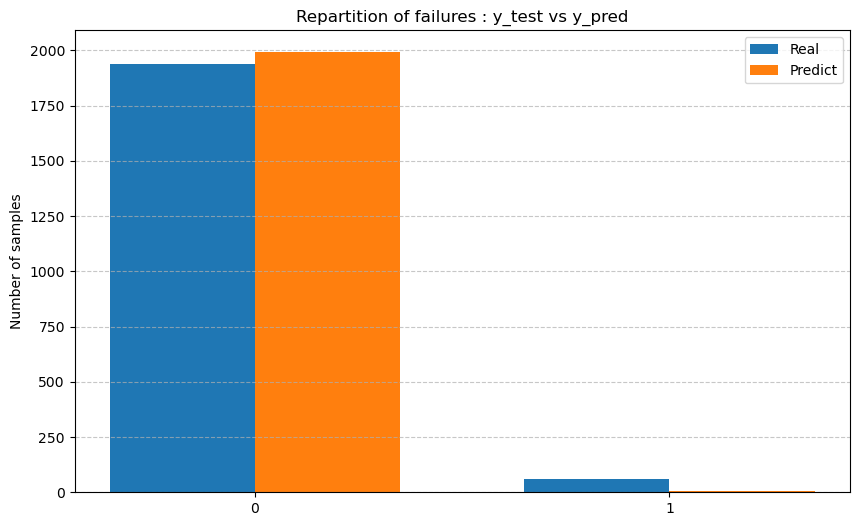

In [38]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Far from the result we want: worse Recall so far.

## With Bagging models then Stacking with Log Reg as meta model

Stacking is fit with smote dataset even though it is not right for LightGBM, it should have a better score as for when KNN and NN are fit with original dataset.

In [39]:
stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn),
    ('bag_lightgbm', bag_lightgbm)], final_estimator=logreg)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [40]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.6610169491525424 | Accuracy: 0.9213 | F1-score: 0.3319


#### Visualization

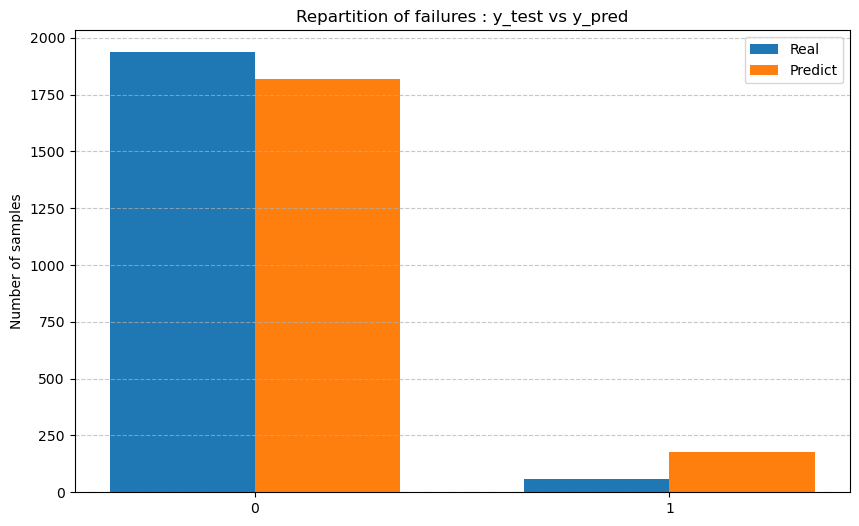

In [41]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It increased the recall so **bagging then Stacking** might be a good lead.

## With Bagging models then Stacking with LightGBM as meta model

Same but using LightGBM instead of Logreg as meta model

In [42]:
stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn)], final_estimator=bag_lightgbm)
stacking_clf.fit(X_train_smote, y_train_smote_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [43]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.576271186440678 | Accuracy: 0.9313 | F1-score: 0.3317


#### Visualization

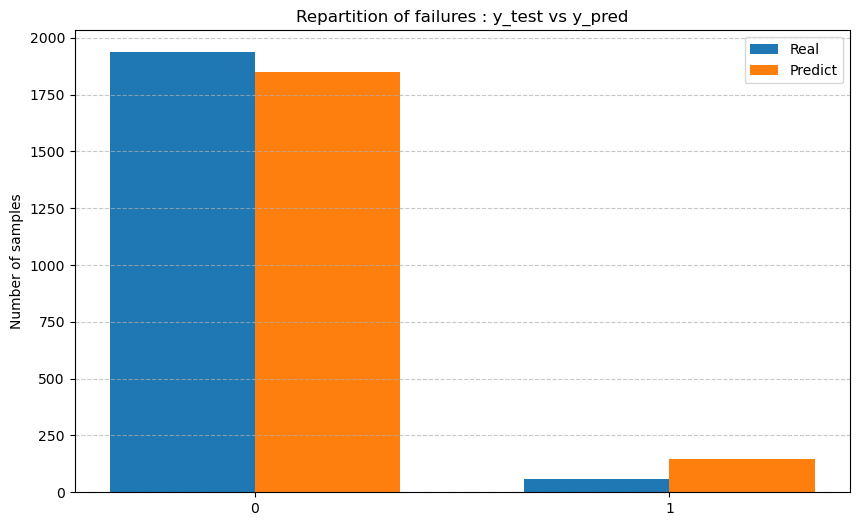

In [44]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [45]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1824,  112],
       [  25,   34]], dtype=int64)

Not bad but not the best

## Bagging models for Stacking with LightGBM as meta model, but SMOTE within pipeline of models

In [48]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', knn) 
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', nn)
])

pipe_lightgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',  lightgbm)
])

bag_knn = BaggingClassifier(
    estimator=pipe_knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=pipe_lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

stacking_clf = StackingClassifier(estimators=[
    ('bag_knn', bag_knn),
    ('bag_nn', bag_nn)], final_estimator=bag_lightgbm)
stacking_clf.fit(X_train, y_train_target)

y_pred_target = stacking_clf.predict(X_test)

Evaluation

In [49]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.4576271186440678 | Accuracy: 0.9825 | F1-score: 0.6067


#### Visualization

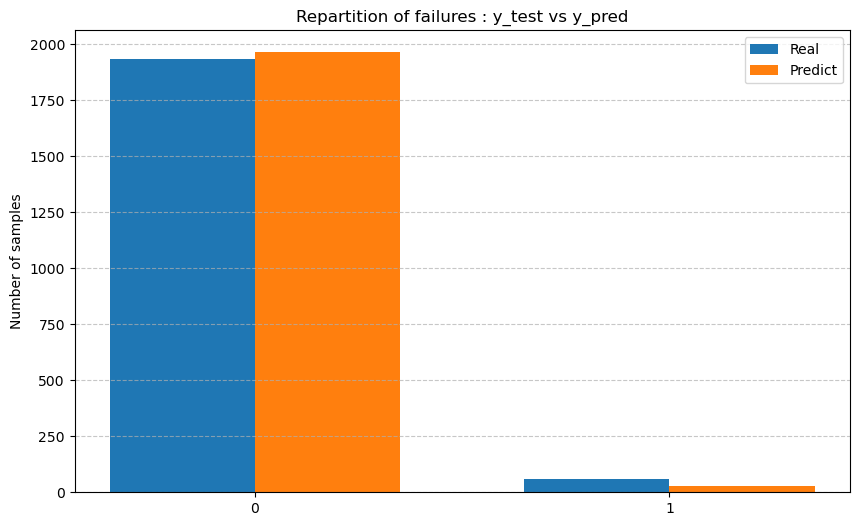

In [50]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [51]:
y_pred_target = pd.DataFrame.from_dict(y_pred_target)

failure_counts = y_test_target.value_counts()
failure_counts_pred = y_pred_target.value_counts()
print(f'Actual repartition: {failure_counts} VS Predicted repartition: {failure_counts_pred}')

Actual repartition: Target
0    1936
1      59
Name: count, dtype: int64 VS Predicted repartition: 0    1965
1      30
Name: count, dtype: int64


In [52]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1933,    3],
       [  32,   27]], dtype=int64)

By doing the SMOTE within the pipeline, we make sure to apply LightGBM on the original dataset contrarly to previous prediction. 
The recall is not really high, it misses almost half of the failures.
However, when we print the confusion matrix, it seems that there are a lot of False Positive and False Negative (explaining this recall score).
In our case this might no be the most appropriate prediction.

## Bagging models for Voting Classifier, but SMOTE within pipeline of models

This might be a compromise

In [53]:
smote = SMOTE(random_state=42)

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', knn) 
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', nn)
])

pipe_lightgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', lightgbm)
])

bag_knn = BaggingClassifier(
    estimator=pipe_knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=pipe_lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_knn', bag_knn),
        ('bag_nn', bag_nn),
        ('bag_lightgbm', bag_lightgbm)
    ],
    voting='hard', 
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_target)

y_pred_target = voting_clf.predict(X_test)

Evaluation

In [54]:
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
print(f"{recall_score(y_test_target,y_pred_target)} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


0.7796610169491526 | Accuracy: 0.9835 | F1-score: 0.7360


#### Visualization

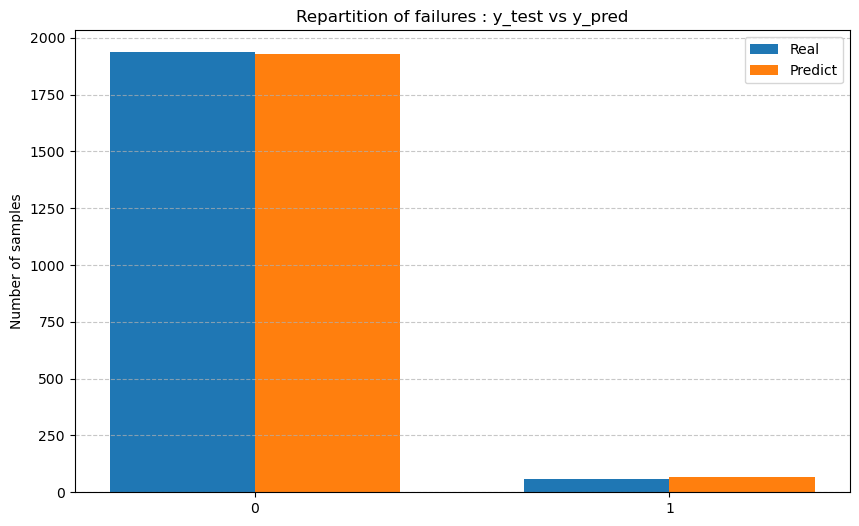

In [55]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [56]:
cm = confusion_matrix(y_test_target, y_pred_target)
cm

array([[1916,   20],
       [  13,   46]], dtype=int64)

This is the **highest recall** so far, recall = 0.7796610169491526, so we can considered this is the best combination: **Bagging the three models (that are SMOTE within the respectiv pipeline for KNN and NN), and appliying a Voting Classifier on them**.

## Conclusion of the best combination for prediction of Target

For the last prediction, we had the highest recall and the best repartition. Other prediction shows us more failures than it should have predict, so it might be a time-wasting to use these predictions knowing that Failure Type will predict if these predictions found a failure.

Our goal is still to maximize recall by keeping a good repartition and still a good precision, so we decided to keep the last configuration: **Bagging the three models (that are SMOTE within the respectiv pipeline for KNN and NN), and appliying a Voting Classifier on them**